In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### Parameters

In [2]:

img_height, img_width = 224, 224
batch_size = 32
epochs = 15
epoch_fine_tune = 20
n_splits = 5
validation_split=0.2


dataset_dir = 'dataset'
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')





### Loading the training and testing data

In [3]:

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=validation_split
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    seed=42
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
   test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 2165 images belonging to 3 classes.
Found 539 images belonging to 3 classes.
Found 301 images belonging to 3 classes.


## Training
### KFold Cross Validation
### Training before and after Fine Tuning

In [4]:
x_data, y_data = [], []
for i in range(len(train_generator)):
    x_batch, y_batch = train_generator[i]
    x_data.append(x_batch)
    y_data.append(y_batch)

x_data = np.concatenate(x_data, axis=0)
y_data = np.concatenate(y_data, axis=0)

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_no = 1
f1_scores = []

for train_idx, val_idx in kf.split(x_data):
    print(f"Training on fold {fold_no}...")

    x_train_fold, x_val_fold = x_data[train_idx], x_data[val_idx]
    y_train_fold, y_val_fold = y_data[train_idx], y_data[val_idx]

    base_model = VGG19(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(img_height, img_width, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(y_train_fold.shape[1], activation="softmax")(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    history = model.fit(
        x_train_fold, y_train_fold,
        validation_data=(x_val_fold, y_val_fold),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=3,
                restore_best_weights=True
            )
        ]
    )

    base_model.trainable = True
    for layer in base_model.layers[:15]:
        layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    fine_tune_history = model.fit(
        x_train_fold, y_train_fold,
        validation_data=(x_val_fold, y_val_fold),
        epochs=epoch_fine_tune,
        batch_size=batch_size,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=3,
                restore_best_weights=True
            )
        ]
    )

    y_val_pred = model.predict(x_val_fold)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true = np.argmax(y_val_fold, axis=1)

    f1 = f1_score(y_val_true, y_val_pred_classes, average="weighted")
    print(f"Fold {fold_no} F1 Score: {f1}")
    f1_scores.append(f1)
    fold_no += 1
    
print(f"Average F1 Score across all folds: {np.mean(f1_scores)}")



Training on fold 1...
Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 333s 6s/step - accuracy: 0.3747 - loss: 1.2134 - val_accuracy: 0.6836 - val_loss: 0.8495
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 406s 7s/step - accuracy: 0.5905 - loss: 0.8732 - val_accuracy: 0.7506 - val_loss: 0.7395
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 323s 6s/step - accuracy: 0.6655 - loss: 0.7742 - val_accuracy: 0.7760 - val_loss: 0.6811
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 603s 11s/step - accuracy: 0.7185 - loss: 0.6981 - val_accuracy: 0.7506 - val_loss: 0.6526
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 507s 9s/step - accuracy: 0.7235 - loss: 0.6613 - val_accuracy: 0.8060 - val_loss: 0.6163
Epoch 6/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 692s 12s/step - accuracy: 0.7458 - loss: 0.6478 - val_accuracy: 0.8060 - val_loss: 0.5902
Epoch 7/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 611s 11s/step - accuracy: 0.7580 - loss: 0.6077 - val_accuracy: 0.8106 - val_loss: 0.5808
Epoch 8/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 621s 11s/step - accuracy: 0.7834 - loss: 0.5861 

### Evaluation

In [5]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



C:\Users\rulas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.9771 - loss: 0.1281
Test Loss: 0.24583011865615845
Test Accuracy: 0.9634551405906677


### Confusion Matrix
### F1 Score, Precision, Recall
### Accuracy and Loss Plots

10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step
F1 Score: 0.9633188063495605
Classification Report:
               precision    recall  f1-score   support

      Broken       0.97      0.98      0.97        98
       Clean       0.95      0.99      0.97        87
       Dirty       0.97      0.93      0.95       116

    accuracy                           0.96       301
   macro avg       0.96      0.97      0.96       301
weighted avg       0.96      0.96      0.96       301



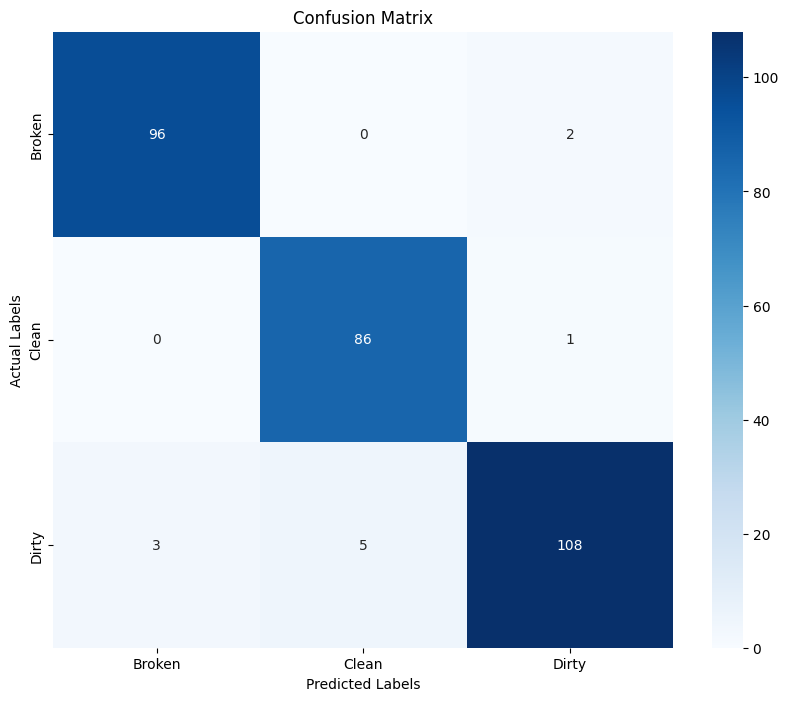

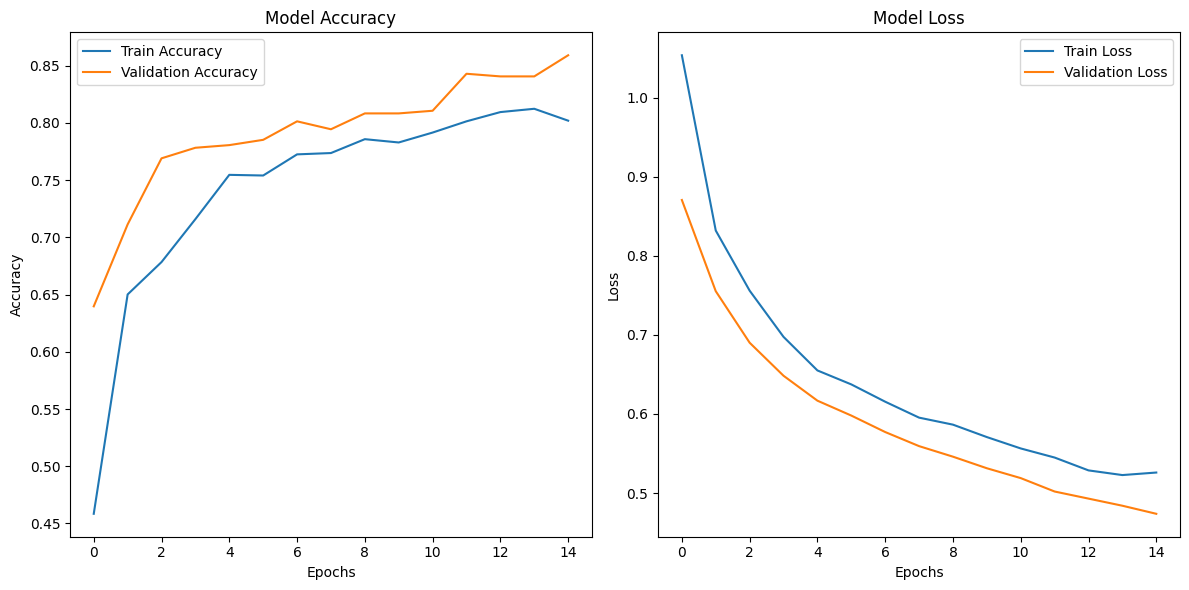

In [8]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

f1 = f1_score(y_true, y_pred_classes, average="weighted")
print(f"F1 Score: {f1}")

class_report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", class_report)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

### ROC Curve

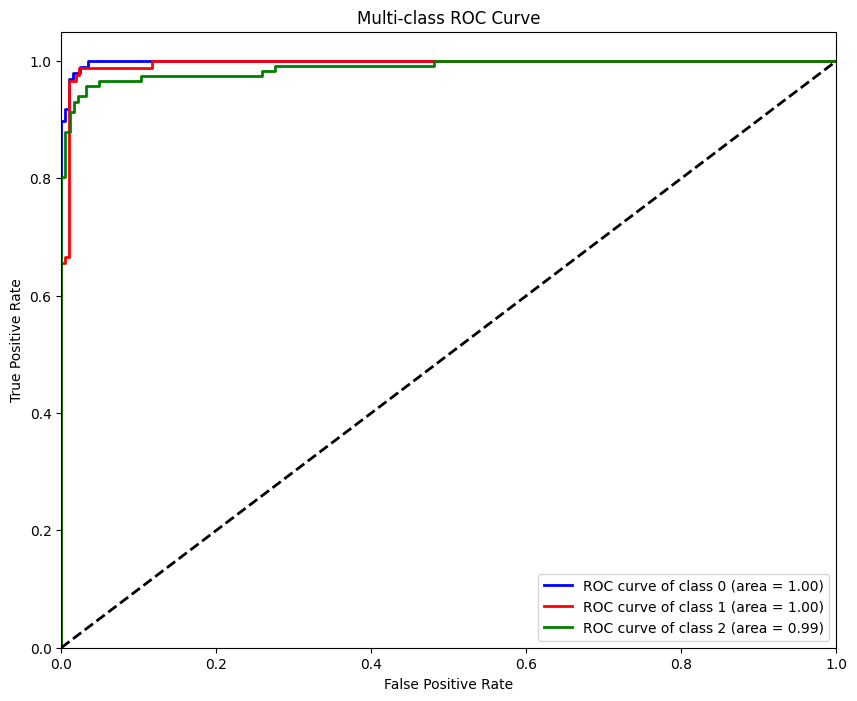

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical
from itertools import cycle


y_true = to_categorical(test_generator.classes, num_classes=len(test_generator.class_indices))

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_true.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))

colors = cycle(['blue', 'red', 'green', 'orange', 'black', 'purple', 'brown', 'pink', 'gray', 'olive'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()